In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from matplotlib.animation import FuncAnimation
import numpy as np
from shapely import geometry
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(color_codes=True)
from mpl_toolkits.basemap import Basemap
import geopandas as gdp
import itertools
from matplotlib import interactive
plt.style.use('bmh')
interactive(True)

In [2]:
# Load Shapefiles
df_dist_d = gdp.read_file('/Users/tjspross/Downloads/layer0_0_dense/')
df_dist_d = df_dist_d.to_crs({'init': 'epsg:4326'})
df_dist_c = gdp.read_file('/Users/tjspross/Downloads/layer0_0_central/')
df_dist_c = df_dist_c.to_crs({'init': 'epsg:4326'})

df_natline = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/natural_line.shp')
df_bound_line = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/boundary_line.shp')
df_highway = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/highway_line.shp')
df_waterway = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/waterway_polygon_polygon.shp')
df_bound_poly = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/boundary_polygon_polygon.shp')
df_bound_poly = df_bound_poly.loc[df_bound_poly['BOUNDARY']!='protected_area']
df_bound_poly = df_bound_poly.loc[df_bound_poly['ADMIN_LEVE']=='6']

In [3]:
# In case publish time and scrape_time are messed up. This happens because scrapy crawler will append dates in text
# format but if using pandas to_json method, dates get written in epoch INT format (defualt unless date_format=None).

dfcheck = pd.read_json("/Users/tjspross/Documents/scrapy_smartshanghai/output/listings.jl",lines=True)
def convert_dates(date):
    if date>1e15:
        return date/1e6
    else:
        return date
new_scrape_time = pd.to_numeric(dfcheck.scrape_time).apply(convert_dates)
new_publish_time = pd.to_numeric(dfcheck.publish_time).apply(convert_dates)
dfcheck.publish_time = pd.to_datetime(new_publish_time,unit='ms')
dfcheck.scrape_time = pd.to_datetime(new_scrape_time,unit='ms')
dfcheck.to_json('/Users/tjspross/Documents/scrapy_smartshanghai/output/listings.jl',
           orient='records',lines=True,date_format=None)

### Read data and filter rows

In [4]:
df = pd.read_json("/Users/tjspross/Documents/scrapy_smartshanghai/output/listings.jl",lines=True)

# Filter null or missing values
df = df.loc[~df['title'].isnull()]
df.loc[df['rooms']!='']

# Filter for

# Create rooms columns
df['rooms'] = df['rooms'].str.replace(', [0-9]* Storage','').str.strip()
df['rooms_BR'] = df['rooms'].str.extract('([0-9]*) Bedroom',0).fillna(0).astype('int')
df['rooms_BA'] = df['rooms'].str.extract('.*, ([0-9]*) Bathroom',0).fillna(0).astype('int')
df['rooms_simple'] = df['rooms_BR'].astype('str') + "BR, "+ df['rooms_BA'].astype('str') + "BA"

# Clean size column
df.set_value(df['size']=='sqm','size',None)
temp=df['size'].str.extract('([0-9]*)\+|([0-9]*)\.|([0-9]*) sqm',expand=False).replace(' ',np.nan).replace('',np.nan).fillna(0)
df['size_int']= temp.astype('int').sum(axis=1)
df.set_value(df['size_int']==0,'size_int',np.nan)

# Filter null size apartments
df = df.loc[~df['size_int'].isnull()]

# Filter by apartment types
df_sublet = df.loc[df['posted_type'].isin(['Shared apartment','Service Apartment'])]
df = df.loc[df['posted_type'].isin(['Apartment for rent','House for rent'])]

# Filter for prices like 10,000 RMB or 10,000 rmb or 10,000 or RMB10,000
df = df.loc[df['price'].str.contains('^[0-9,]{3,} RMB$|^[0-9,]{3,} rmb$|^[0-9,]{3,}$|^RMB[0-9,]{3,}$')]
# Strip unnecessary characters and convert to int
df['price']=df['price'].str.replace('RMB', '', case=True).str.replace(',','').str.strip().astype('int')
df = df.loc[~df['price'].isnull()]

# Filter sublets that appear in 'Apartments for rent'
sublets = df.loc[
    (df['description'].str.contains('overtake|leaving|take over|sublet|roommate|roomate|bedroom available')) & 
    (df['rooms_BR']>=2) &
    (df['price']<10000)]['listing_id']
sublets4= df.loc[(df['rooms_BR']>=4) & (df['price']<=5000)]['listing_id']
sublets3= df.loc[(df['rooms_BR']==3) & (df['price']<=3000)]['listing_id']

df = df.loc[~df.listing_id.isin(sublets4)]
df = df.loc[~df.listing_id.isin(sublets3)]
df = df.loc[~df.listing_id.isin(sublets)]



# Price per Square Meter
df['price_per_meter'] = df['price']/df['size_int']

# Filter very cheap and very expensive PPM apartments (likely input errors)
df = df.loc[~(df['price_per_meter']<30)]
df = df.loc[~(df['price_per_meter']>600)]

# # Filter apartments by price
# for i in xrange(0,4):
#     # filtering out top 1% apartments 
#     upper_lim = df.loc[df['rooms_BR']==i]['price'].quantile(0.99)
#     df = df.loc[~((df['price']>upper_lim) & (df['rooms_BR']==i))]

# # filtering out 4 bedrooms more than 70,000 RMB and less tahn 8000 RMB. This analysis does not concern luxury apartments
# df = df.loc[~((df['price']<8000) & (df['rooms_BR']==4))]
# df = df.loc[~((df['price']>=70000) & (df['rooms_BR']==4))]
# # filtering out 3 bedrooms less than 7000, 6000 seems to be a better cutoff
# df = df.loc[~((df['price']>=50000) & (df['rooms_BR']==3))]
# df = df.loc[~((df['price']<7000) & (df['rooms_BR']==3))]
# # filtering out 2 bedrooms less than 4500, there are some 2BR in Jiading or Putuo for 4500 or 5k
# df = df.loc[~((df['price']<4500) & (df['rooms_BR']==2))]
# df = df.loc[~((df['price']>=30000) & (df['rooms_BR']==2))]


# Filter for apartments with too many rooms
df = df.loc[df['rooms_BR'].isin([1,2,3,4,5,6,7])]

# Filter test/fake listings
df = df.loc[~df.title.str.contains('^Test|^test| test')]
df = df.loc[~df.description.str.contains('^Test|^test| test')]

# Filter for obscenely small rooms given the number of bedrooms, and rooms too large (most likely input error)
br_sizelimit = [
    {"rooms_BR":1,"low_limit":10,"up_limit":200},
    {"rooms_BR":2,"low_limit":40,"up_limit":240},
    {"rooms_BR":3,"low_limit":70,"up_limit":350},
    {"rooms_BR":4,"low_limit":90,"up_limit":510},
    {"rooms_BR":5,"low_limit":100,"up_limit":550},
    {"rooms_BR":6,"low_limit":120,"up_limit":600},
    {"rooms_BR":7,"low_limit":140,"up_limit":600},
]
filt_listings = []

for a in br_sizelimit:
        filt_listings.extend(df.loc[(df['rooms_BR']==a['rooms_BR']) & 
                                    (df['size_int']<a['low_limit'])]['listing_id'].tolist())
        filt_listings.extend(df.loc[(df['rooms_BR']==a['rooms_BR']) & 
                                    (df['size_int']>a['up_limit'])]['listing_id'].tolist())
df = df.loc[~df['listing_id'].isin(filt_listings)]

# Filter listings manually
excl = [962432,881214,911428,942291,876186,876808,949240,868200,941561]
df = df.loc[~df['listing_id'].isin(excl)]

# Filter listings with no geolocation data
df = df.loc[df['longitude'].astype('str') !='']
df = df.loc[df['latitude'].astype('str')!='']

### Create main df columns

In [5]:
# Truncate publish_time column into dates and months
df['publish_date'] = df['publish_time'].dt.date
df['publish_month'] = pd.to_datetime(dict(year=df['publish_time'].dt.year, month=df['publish_time'].dt.month, day=1))
df['pub_month'] = df['publish_month'].dt.month
df['publish_week']=(df['publish_time'] - pd.to_timedelta(df['publish_time'].dt.dayofweek, unit='d')).dt.date

# create bool column for top 5% size apartments
top5_size = []
for a in [1,2,3,4,5,6]:
    top5_threshold = df.loc[df['rooms_BR']==a]['size_int'].quantile(0.95)
    top5_size.extend(df.loc[(df['rooms_BR']==a) & (df['size_int']>=top5_threshold)]['listing_id'].tolist())
df['top5_size'] = df['listing_id'].isin(top5_size)

# Define columns
main_cols = ['area','author','description','floor','latitude',
             'longitude','listing_id','posted_type','price','publish_time','rooms','size','title']
checkbox_cols = ['air_filter','central_aircon','balcony','dryer','dvd_player','elevator',
                 'floor_heating','health_club','outdoor_space','oven','parking','playground','pool',
                'security','tv','wall_heating','washing_machine','water_filter']

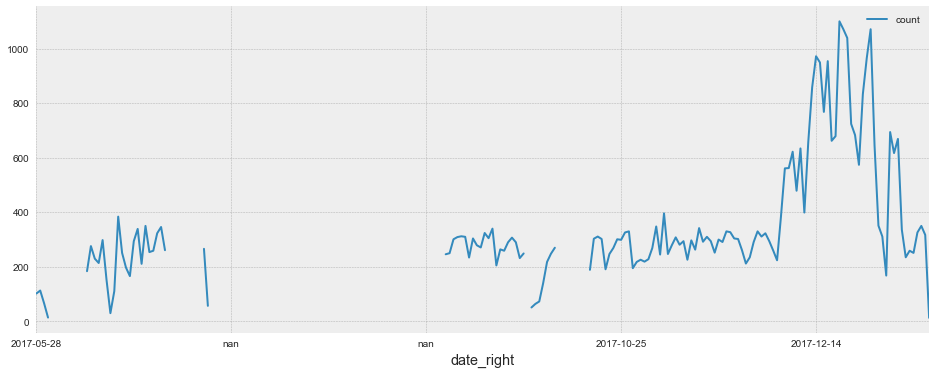

In [6]:
# Visualize number of listings pulled by date
start = df.publish_time.min()
stop = df.publish_time.max()
dates_dense=[]
from datetime import timedelta
for a in xrange(0,(stop-start).days + 1,1):
    dates_dense.append(start.date() + timedelta(days=a))
df_date_left = pd.DataFrame(dates_dense,columns=['date_left'])
df_date_left['count']=0
df_date_right = pd.DataFrame(df.publish_date.value_counts())
df_date_right['count']=df_date_right['publish_date']
df_date_right['date_right'] = df_date_right.index
df_dates = pd.merge(df_date_left,df_date_right,how='left',left_on='date_left',right_on='date_right')
df_dates['count'] = df_dates['count_x'] + df_dates['count_y']
# df_dates.fillna(0)
df_dates.plot(kind='line',x='date_right',y='count',figsize=(16,6))
plt.show()

### Combine shapefile geoDataframe with df

In [7]:
def checkarea(value,geoDataFrame):
    area = geoDataFrame.loc[geoDataFrame['geometry'].contains(geometry.Point(value[0],value[1]))]['TITLE']
    if area.empty:
        return None
    else:
        return area.tolist()[0]
df['district_dense'] = df[['longitude','latitude']].astype('float').apply(checkarea,args=(df_dist_d,),axis=1)

# Filtering out duplicates
df = df.drop_duplicates(['description','size_int','author','district_dense','rooms_BA','rooms_BR'])

# Create bool column for top 5% ppm for district
top5_ppm = []
for a in np.unique(df.district_dense):
    top5_threshold = df.loc[df['district_dense']==a]['price_per_meter'].quantile(0.95)
    top5_ppm.extend(df.loc[(df['district_dense']==a) & (df['price_per_meter']>=top5_threshold)]['listing_id'].tolist())
df['top5_ppm_per_district'] = df['listing_id'].isin(top5_ppm)

def makegeoseris(value):
    return geometry.Point(value[0],value[1])
df['geometry']=df[['longitude','latitude']].astype('float').apply(makegeoseris,axis=1)
df = gdp.GeoDataFrame(df)

In [8]:
def count_poly_pt(df,groupby_col=None,output_col=None):
    counts=pd.DataFrame(df.loc[~df[groupby_col].isnull()][groupby_col].value_counts())
    counts.columns=[output_col]
    counts['TITLE']=counts.index
    counts.set_index("TITLE")
    return counts[output_col]
df_dist_d = df_dist_d.filter(regex='^(?!count)')

if df_dist_d.filter(regex='count').empty:
    df_dist_d = df_dist_d.join(count_poly_pt(df,'district_dense','count'),on='TITLE')
    df_dist_d = df_dist_d.join(count_poly_pt(df.loc[df['rooms_BR']==1],'district_dense','count_1br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_poly_pt(df.loc[df['rooms_BR']==2],'district_dense','count_2br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_poly_pt(df.loc[df['rooms_BR']==3],'district_dense','count_3br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_poly_pt(df.loc[df['rooms_BR']==4],'district_dense','count_4br'),on='TITLE')

In [9]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def agg_price(func, df=None, rooms_br=None, groupby_col=None,col='price'):
    if callable(func):
        func_name=func.__name__
    else:
        func_name=func
    gb = pd.DataFrame(df.loc[(df['rooms_BR']==rooms_br)].groupby(groupby_col).agg(func)[col])
    colname = "%s_%s_%sbr"% (col,func_name, rooms_br)
    gb.columns = [colname]
    if col=='price':
        gb[colname + "_text"] = gb.apply(lambda x: "{:,.0f} CNY".format(np.round(x[colname]),0), axis=1)
    elif col=='size_int':
        gb[colname + "_text"] = gb.apply(lambda x: "{:,.0f} Sq Meters".format(np.round(x[colname]),0), axis=1)
    gb.TITLE=  gb.index
    return gb

functions = ['mean','median',percentile(10),percentile(25),percentile(75),percentile(90)]
rooms = [1,2,3,4]
# calculate 1br,2br,3br mean median etc values
for a,b in itertools.product(functions,rooms):
    if callable(a):
        func_name=a.__name__
    else:
        func_name=a
    if df_dist_d.filter(regex="price_" + func_name + "_%sbr" % b).empty:
        df_dist_d = df_dist_d.join(
            agg_price(a,df=df, rooms_br=b, groupby_col='district_dense'),
            on='TITLE'
        )
# Aggregate same data above for size_int column
for a,b in itertools.product(functions,rooms):
    if callable(a):
        func_name=a.__name__
    else:
        func_name=a
    if df_dist_d.filter(regex="size_int_" + func_name + "_%sbr" % b).empty:
        df_dist_d = df_dist_d.join(
            agg_price(a,df=df, rooms_br=b, groupby_col='district_dense',col='size_int'),
            on='TITLE',
        )

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [10]:
df_dist_d.columns

Index([                          u'TITLE',                         u'VISIBLE',
                            u'DESCRIPTIO',                       u'IMAGE_URL',
                            u'IMAGE_LINK',                            u'DATE',
                                u'TYPEID',                      u'Shape_Leng',
                            u'Shape_Area',                        u'geometry',
       ...
            u'size_int_percentile_75_4br', u'size_int_percentile_75_4br_text',
            u'size_int_percentile_90_1br', u'size_int_percentile_90_1br_text',
            u'size_int_percentile_90_2br', u'size_int_percentile_90_2br_text',
            u'size_int_percentile_90_3br', u'size_int_percentile_90_3br_text',
            u'size_int_percentile_90_4br', u'size_int_percentile_90_4br_text'],
      dtype='object', length=111)

In [11]:
top5size_count = df.groupby('district_dense').agg({'top5_size':'sum'})
top5size_count['TITLE']=top5size_count.index
df_dist_d = df_dist_d.merge(top5size_count,on='TITLE')
df_dist_d['top5_size_perc'] = np.round(100*df_dist_d['top5_size']/df_dist_d['count'],2)

In [12]:
agg_ppm_temp = df.groupby('district_dense').agg({'price_per_meter':
                                     ['mean',np.std,percentile(10),percentile(25),percentile(50),percentile(75),percentile(90)]}
                                   ).round(1)
agg_ppm = pd.DataFrame(agg_ppm_temp['price_per_meter']['mean'].reset_index())

agg_ppm['ppm_median'] = agg_ppm_temp['price_per_meter']['percentile_50'].values
agg_ppm['ppm_std'] = agg_ppm_temp['price_per_meter']['std'].values
agg_ppm['ppm_percentile_90'] = agg_ppm_temp['price_per_meter']['percentile_90'].values
agg_ppm.columns=['TITLE','ppm_mean','ppm_median','ppm_std','ppm_percentile_90']
df_dist_d = df_dist_d.merge(agg_ppm,on='TITLE',how='left')

1 Bedroom Size 95th Percentile:
	90.0


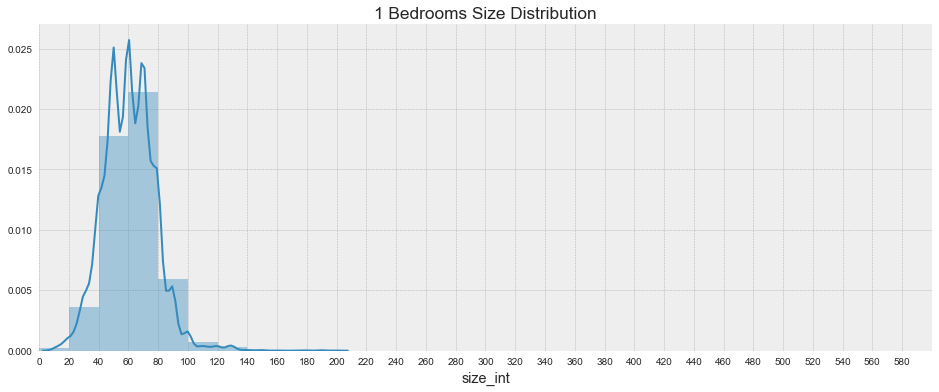

2 Bedroom Size 95th Percentile:
	140.0


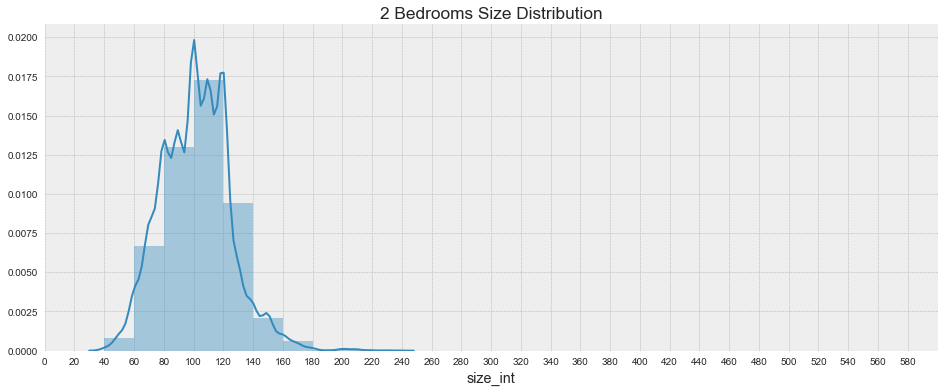

3 Bedroom Size 95th Percentile:
	200.0


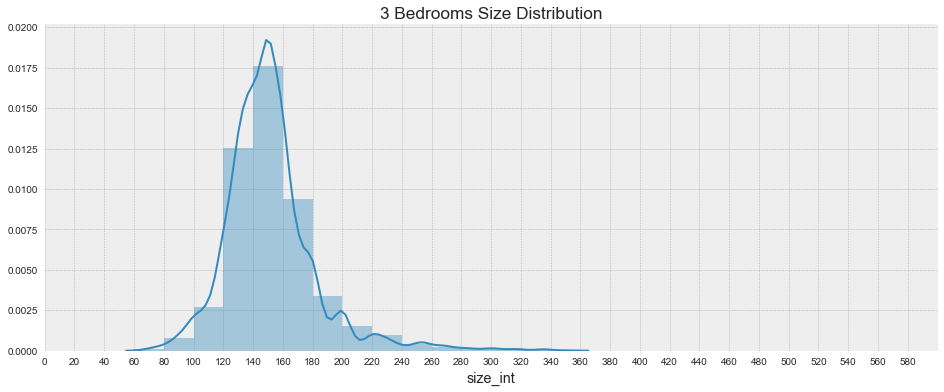

4 Bedroom Size 95th Percentile:
	304.0


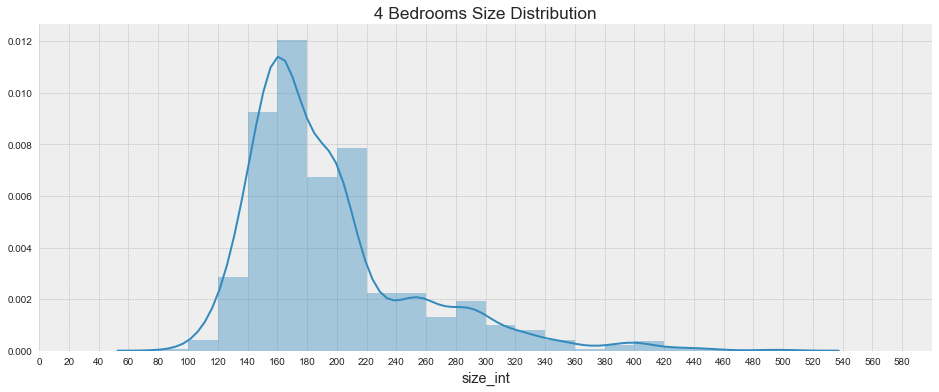

5 Bedroom Size 95th Percentile:
	466.0


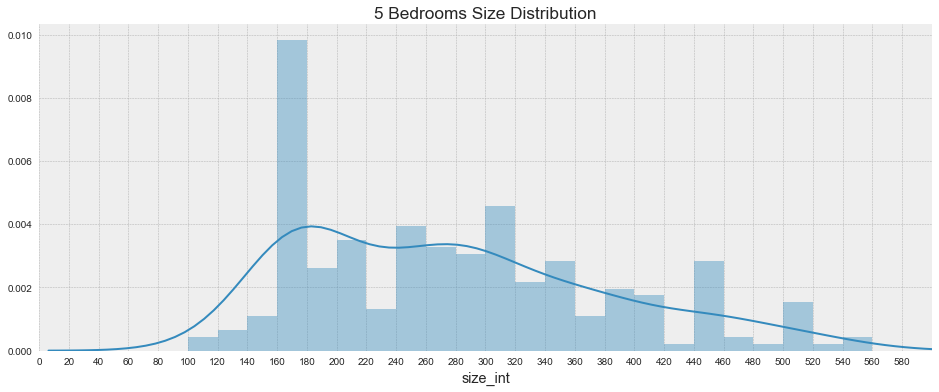

In [13]:
for a in [1,2,3,4,5]:
    plt.figure(figsize=(16,6))
    size_series = df.loc[(df['rooms_BR']==a) &  (df['size_int'].notnull())]['size_int']
    sns.distplot(size_series,bins=np.arange(0,600,20))
    print "%s Bedroom Size 95th Percentile:\n\t%s" % (a,size_series.quantile(.95))
    plt.title("%s Bedrooms Size Distribution" % a)
    plt.xticks(np.arange(0,600,20))
    plt.xlim(0,600)
    plt.show()

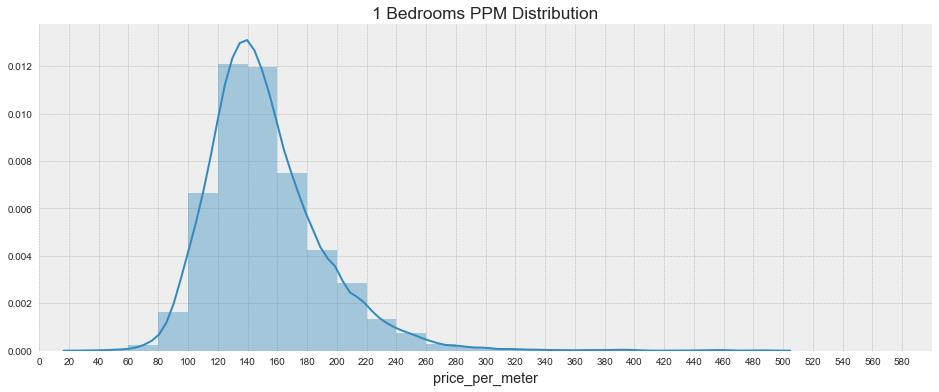

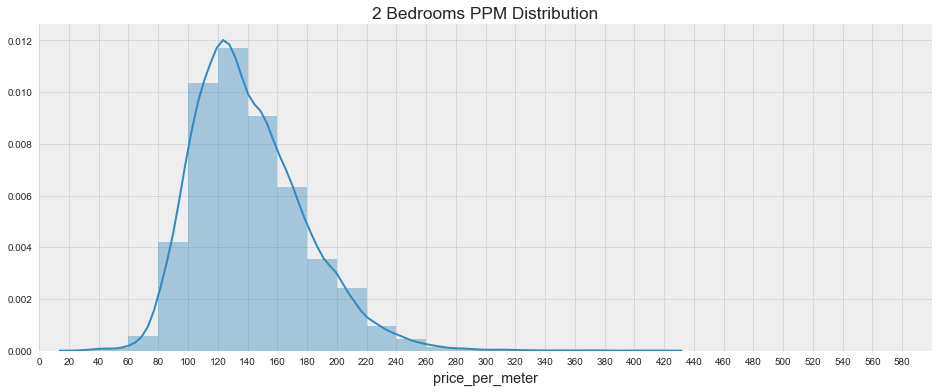

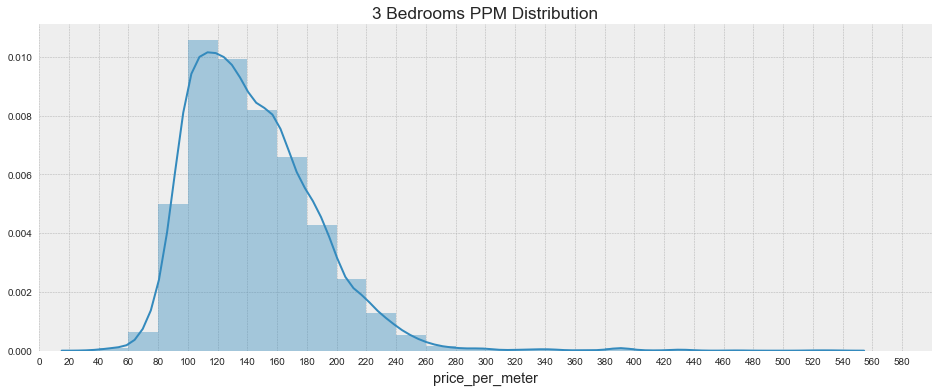

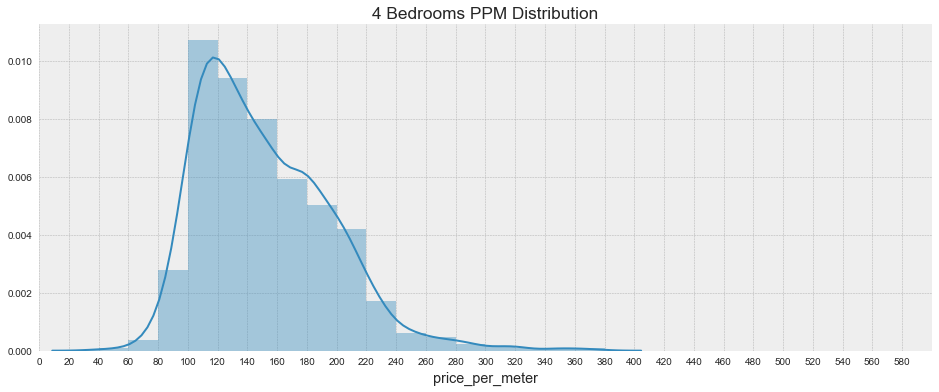

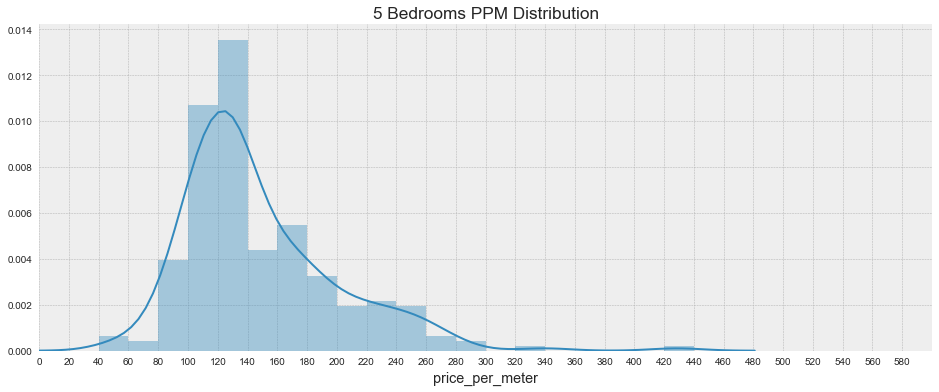

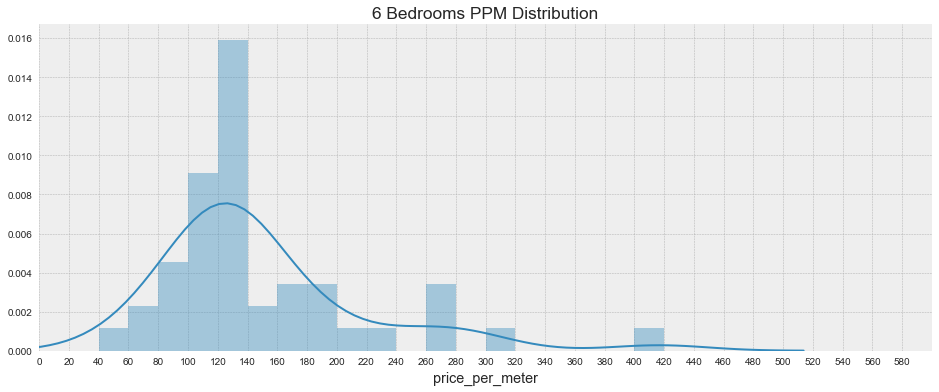

In [14]:
for a in [1,2,3,4,5,6]:
    plt.figure(figsize=(16,6))
    ppm_series = df.loc[(df['rooms_BR']==a) &  (df['size_int'].notnull()) &
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price_per_meter']
    sns.distplot(ppm_series,bins=np.arange(0,600,20))
#     print "%s Bedroom Size 95th Percentile:\n\t%s" % (a,size_series.quantile(.95))
    plt.title("%s Bedrooms PPM Distribution" % a)
    plt.xticks(np.arange(0,600,20))
    plt.xlim(0,600)
    plt.show()

In [15]:
for a in [1,2,3,4,5,6]:
    print "%s Bedrooms 95th percentile square meterage: %s"% (a,df.loc[df['rooms_BR']==a]['size_int'].quantile(0.95))

1 Bedrooms 95th percentile square meterage: 90.0
2 Bedrooms 95th percentile square meterage: 140.0
3 Bedrooms 95th percentile square meterage: 200.0
4 Bedrooms 95th percentile square meterage: 304.0
5 Bedrooms 95th percentile square meterage: 466.0
6 Bedrooms 95th percentile square meterage: 500.0


In [16]:
agg_size_temp = df.groupby('district_dense').agg({'size_int':
                                     ['mean',np.std,percentile(10),percentile(25),percentile(50),percentile(75),
                                      percentile(90),percentile(95),percentile(99)]}
                                   ).round(1)
agg_size = pd.DataFrame(agg_size_temp['size_int']['mean'].reset_index())

agg_size['size_median'] = agg_size_temp['size_int']['percentile_50'].values
agg_size['size_std'] = agg_size_temp['size_int']['std'].values
agg_size['size_percentile_90'] = agg_size_temp['size_int']['percentile_90'].values
agg_size['size_percentile_95'] = agg_size_temp['size_int']['percentile_95'].values
agg_size['size_percentile_99'] = agg_size_temp['size_int']['percentile_99'].values
agg_size
agg_size.columns=['TITLE','size_mean','size_median','size_std','size_percentile_90','size_percentile_95',
                  'size_percentile_99']
df_dist_d = df_dist_d.merge(agg_size,on='TITLE',how='left')

In [17]:
elev = df.groupby('district_dense')['elevator'].agg(['sum','count'])
elev['perc_elev'] = elev['sum']/elev['count']

df_dist_c = df_dist_c.loc[:, df_dist_c.columns != 'perc_elev'].join(elev['perc_elev'],on='TITLE')
df_dist_c['perc_laofang'] = 1-df_dist_c['perc_elev']
df_dist_d = df_dist_d.loc[:, df_dist_d.columns != 'perc_elev'].join(elev['perc_elev'],on='TITLE')
df_dist_d['perc_laofang'] = 1-df_dist_d['perc_elev']
df_dist_d['perc_laofang_text'] = df_dist_d['perc_laofang'].apply(lambda x: "{} %".format(100*np.round(x,3), axis=1))

In [18]:
# def round_and_combine(value):
#     return tuple(np.round(value,3))
# df['lat_long'] = df[['latitude', 'longitude']].apply(round_and_combine, axis=1)
# df['lat_long'].value_counts()

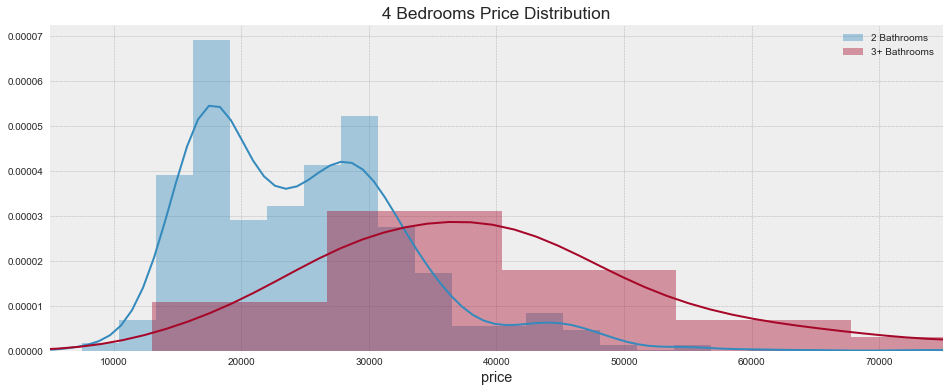

In [19]:
plt.figure(figsize=(16,6))
# sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']==1) & 
#                     (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
#              bins=25,label='1 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']==2)]['price'],
             bins=25,label='2 Bathrooms') 
sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']>=3)]['price'],
             bins=10,label='3+ Bathrooms')
# sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']>3) & 
#                     (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
#              bins=50,label='4+ Bathrooms')
plt.title("4 Bedrooms Price Distribution")

plt.legend()
plt.xlim(5000,75000)
plt.show()

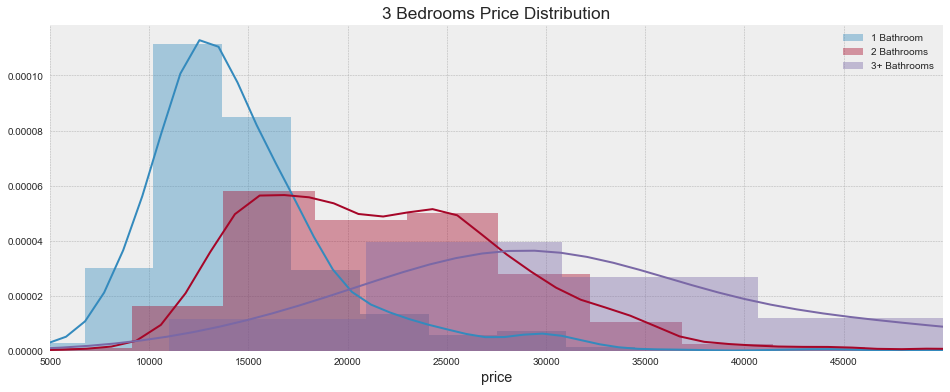

In [20]:
plt.figure(figsize=(16,6))
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']==1) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='1 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']==2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='2 Bathrooms')
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']>2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=10,label='3+ Bathrooms')
plt.title("3 Bedrooms Price Distribution")
plt.legend()
plt.xticks(np.arange(5000,50000,5000))
plt.xlim(5000,50000)
plt.show()

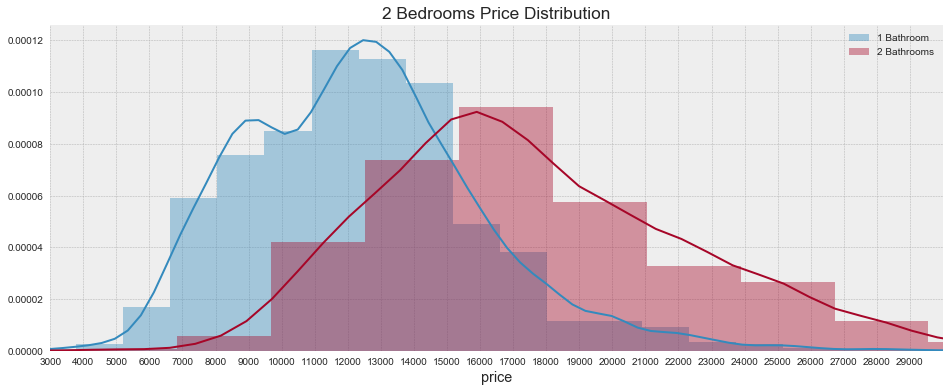

In [21]:
plt.figure(figsize=(16,6))
sns.distplot(df.loc[(df['rooms_BR']==2) & (df['rooms_BA']==1) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='1 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==2) & (df['rooms_BA']==2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='2 Bathrooms')
plt.title("2 Bedrooms Price Distribution")
plt.legend()
plt.xticks(np.arange(3000,30000,1000))
plt.xlim(3000,30000)
plt.show()

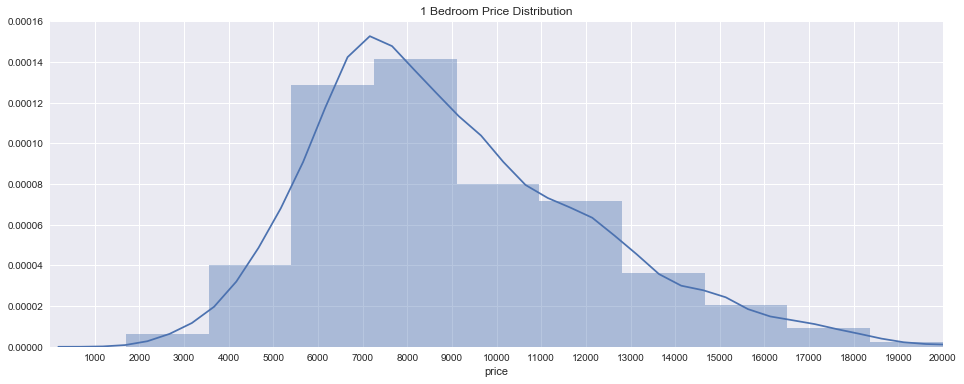

In [22]:
plt.figure(figsize=(16,6))
sns.set(color_codes=True)
sns.distplot(df.loc[(df['rooms_BR']==1) & (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],bins=25)
plt.title("1 Bedroom Price Distribution")
plt.xticks(np.arange(1000,21000,1000))
plt.xlim(0,20000)
plt.show()

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

y = df['price']
X = df['size_int'].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LinearRegression(normalize=True)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
r2_score(y_test,y_pred)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.70931357551982699

In [25]:
df[['price','size_int']].corr()

,price,size_int
price,1.000000,0.835079
size_int,0.835079,1.000000


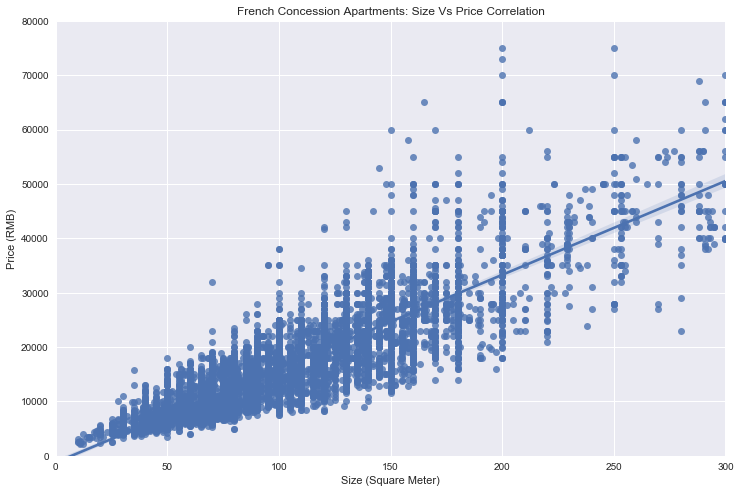

In [38]:
plt.figure(figsize=(12,8))
sns.set(color_codes=True)
ffc = ['Yongkang Street','South Shaanxi Rd','Central Xintiandi','Southern Xintiandi'
       'Fuxing Park','Changshu Rd','West Nanjing Rd','Jing An Temple','Shanghai Library']
sns.regplot(df.loc[df['district_dense'].isin(ffc)]['size_int'],df.loc[df['district_dense'].isin(ffc)]['price'])
plt.xlim(0,300)
plt.xlabel('Size (Square Meter)')
plt.ylabel('Price (RMB)')
plt.ylim(0,80000)
plt.title('French Concession Apartments: Size Vs Price Correlation')
plt.show()

160.0

164.520962623


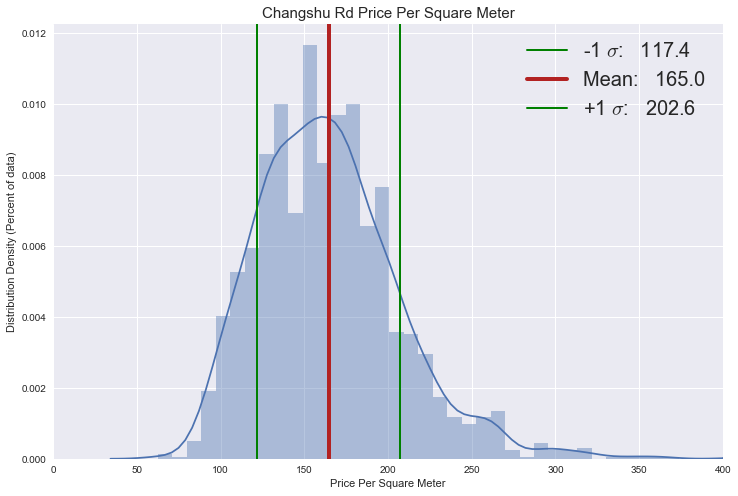

In [84]:
median = df.loc[df['district_dense']=='Changshu Rd']['price_per_meter'].median()
mean = df.loc[df['district_dense']=='Changshu Rd']['price_per_meter'].mean()
print mean
std  = df.loc[df['district_dense']=='Changshu Rd']['price_per_meter'].std()
plt.figure(figsize=(12,8))
sns.set(color_codes=True)
sns.distplot(df.loc[df['district_dense']=='Changshu Rd']['price_per_meter'])
plt.xlim(0,400)
plt.plot([mean - std,mean - std],[0,1],label=r'-1 $\sigma$:   %s ' % (np.round(median -std,1)),linewidth=2,color='green')
plt.plot([mean,mean],[0,1],label='Mean:   %s' % np.round(mean,0),linewidth=4,color='firebrick')
plt.plot([mean + std,mean + std],[0,1],label=r'+1 $\sigma$:   %s ' % (np.round(median +std,1)),linewidth=2,color='green')
plt.legend(fontsize=20)
plt.xlabel('Price Per Square Meter')
plt.ylabel('Distribution Density (Percent of data)')
plt.title('Changshu Rd Price Per Square Meter',fontsize=15)
plt.show()

fig size: 72.0 DPI, size in inches [ 12.   8.]
timestep 0
timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 0


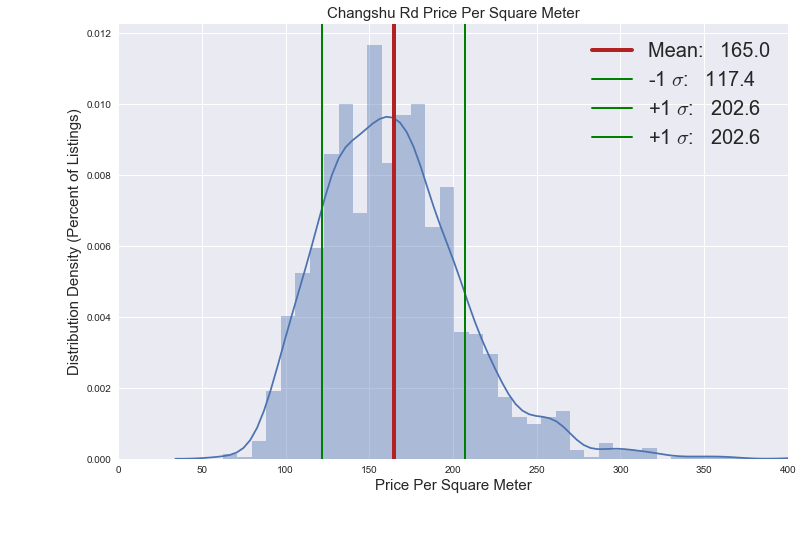

In [103]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(12,8))
# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# Plot a scatter that persists (isn't redrawn) and the initial line.

sns.set(color_codes=True)
sns.distplot(df.loc[df['district_dense']=='Changshu Rd']['price_per_meter'])
plt.xlim(0,400)

plt.xlabel('Price Per Square Meter',fontsize=15)
plt.ylabel('Distribution Density (Percent of Listings)',fontsize=15)
plt.title('Changshu Rd Price Per Square Meter',fontsize=15)


def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    if i==2:
        ax.plot([mean,mean],[0,1],label='Mean:   %s' % np.round(mean,0),linewidth=4,color='firebrick')
    if i==3:
        ax.plot([mean - std,mean - std],[0,1],label=r'-1 $\sigma$:   %s ' % (np.round(median -std,1)),linewidth=2,color='green')
    if i in [4,5]:
        ax.plot([mean + std,mean + std],[0,1],label=r'+1 $\sigma$:   %s ' % (np.round(median +std,1)),linewidth=2,color='green')
    plt.legend(fontsize=20)
    return ax

anim = FuncAnimation(fig, update, frames=np.arange(0, 6), interval=1000)
anim.save('/Users/tjspross/Downloads/line.gif', dpi=70, writer='imagemagick')

## Number of Listings

In [161]:
from bokeh.palettes import viridis,RdBu,Viridis256
from bokeh.models import ColorBar, LogColorMapper
from bokeh.io import output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, CategoricalColorMapper, LinearColorMapper
from bokeh.plotting import figure, show
from bokeh.palettes import Category10
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
from bokeh.models import Arrow, OpenHead, NormalHead, VeeHead
from bokeh.models import Span
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.plotting import output_file, save, reset_output


def bokeh_plot_shanghai(df=None, field=None,hover_tooltip=None,title="", cutoff_field='count',
                        cutoff_count=50, excluded_districts=[],
                        color_mapper=None,**kwargs):
    reset_output()
    fig = figure(title=title, **kwargs)
    fig.patches(
        xs='xs', 
        ys='ys', 
        alpha=0.9, 
        source = GeoJSONDataSource(geojson=df.loc[
    (df[cutoff_field]>=cutoff_count) & (~df['TITLE'].isin(excluded_districts))].to_json()), 
                color={'field': field, 'transform': color_mapper}, 
                line_width=1, line_alpha=0.5, line_color='black')

    df_gray = df.loc[(df[cutoff_field]<=cutoff_count)|(df['TITLE'].isin(excluded_districts))].copy()
    if not df_gray.empty:
        df_gray.loc[:,field]=''
        df_gray.loc[:,'count']=''

        fig.patches(xs='xs', ys='ys', alpha=0.9, 
                    source=GeoJSONDataSource(geojson=df_gray.to_json()), 
                    color='lightgray', legend='Not Enough Listings to Compare',
                    line_width=1, line_alpha=0.5, line_color='firebrick',line_dash = [6, 3])

        
    fig.add_tools(
        HoverTool(
            point_policy='follow_mouse',
            tooltips=hover_tooltip
        )
    )

    color_bar = ColorBar(color_mapper=color_mapper, 
                         location=(0, 0), 
                         label_standoff=12)
    fig.add_layout(color_bar, 'right')

    fig.xaxis.visible = False
    fig.yaxis.visible = False
    fig.grid.visible = False
    return fig


fig = bokeh_plot_shanghai(df=df_dist_d, field='count',cutoff_count=0,
                    title='Smartshanghai Listings',plot_width=1000, plot_height=700,
                         color_mapper = LinearColorMapper(RdBu[11]),
                         hover_tooltip=[('District','@TITLE'),("Listings",'@count')]
                         )
show(fig)
reset_output()

## Apartment Vs LaoFang Likelihood

In [ ]:
df_dist_d['perc_laofang_round'] = df_dist_d['perc_laofang'].apply(lambda x: str(100*np.round(x,3)) + "%" )

fig = bokeh_plot_shanghai(
    df=df_dist_d,field='perc_laofang',cutoff_count=20,
    title='Apartment Building Likelihood',plot_width=1000, plot_height=700,
    color_mapper = LinearColorMapper(RdBu[11]),
    hover_tooltip=[('District','@TITLE'),("Percent Laofang",'@perc_laofang_round'),("Listings",'@count')]
)
show(fig)

# Big Homes (for 1BR, 2BR etc) count by district

In [ ]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='top5_size',cutoff_count=50,
                    title='Big Homes Count by District',plot_width=1000, plot_height=700,
                    color_mapper = LogColorMapper(RdBu[9]),
                    hover_tooltip=[('District','@TITLE'),("Big Homes Count",'@top5_size'),\])
show(fig)

In [ ]:
pd.set_option('max_colwidth',600)
df.loc[df['description'].str.contains('jiading|Jiading')][['author','description','title','price','listing_id','size_int','price_per_meter'
]]

# Mean 1Br Size

In [ ]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='size_int_mean_1br',cutoff_count=30,
                    title='Mean 1BR Size',plot_width=1000, plot_height=700,
                    excluded_districts = ['Tiantong Rd'],
                    color_mapper = LogColorMapper(RdBu[9]),
                    cutoff_field = 'count_1br',
                    hover_tooltip=[('District','@TITLE'),("Mean 1BR Size",'@size_int_mean_1br_text'),('1BR Listings','@count_1br')])
show(fig)

# Mean 2BR Size

In [ ]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='size_int_mean_2br',cutoff_count=30,
                    title='Mean 2BR Size',plot_width=1000, plot_height=700,
                    excluded_districts = ['Tiantong Rd'],
                    color_mapper = LogColorMapper(RdBu[9]),
                    cutoff_field = 'count_2br',
                    hover_tooltip=[('District','@TITLE'),("Mean 2BR Size",'@size_int_mean_2br_text'),('1BR Listings','@count_2br')])
show(fig)

# Median 1BR Size

In [ ]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='size_int_median_1br',cutoff_count=50,
                    title='Median 1BR Size',plot_width=1000, plot_height=700,
                    excluded_districts = ['Tiantong Rd'],
                    color_mapper = LogColorMapper(RdBu[9]),
                    cutoff_field = 'count_1br',
                    hover_tooltip=[('District','@TITLE'),("Median 1BR Size",'@size_int_median_1br_text'),('1BR Listings','@count_1br')])
show(fig)

# Median 2BR Size

In [109]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='size_int_median_2br',cutoff_count=50,
                    title='Median 2BR Size',plot_width=1000, plot_height=700,
                    excluded_districts = ['Tiantong Rd'],
                    color_mapper = LogColorMapper(RdBu[9]),
                    cutoff_field = 'count_2br',
                    hover_tooltip=[('District','@TITLE'),("Median 2BR Size",'@size_int_median_2br_text'),('2BR Listings','@count_2br')])
show(fig)
reset_output()

# Median 3BR Size

In [ ]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='size_int_median_3br',cutoff_count=50,
                    title='Median 3BR Size',plot_width=1000, plot_height=700,
                    excluded_districts = ['Tiantong Rd'],
                    color_mapper = LogColorMapper(RdBu[9]),
                    cutoff_field = 'count_3br',
                    hover_tooltip=[('District','@TITLE'),("Median 3BR Size",'@size_int_median_3br_text'),('3BR Listings','@count_3br')])
show(fig)

# Median 4BR Size

In [ ]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='size_int_median_4br',cutoff_count=30,
                    title='Median 4BR Size',plot_width=1000, plot_height=700,
                    excluded_districts = ['Tiantong Rd'],
                    color_mapper = LogColorMapper(RdBu[9]),
                    cutoff_field = 'count_4br',
                    hover_tooltip=[('District','@TITLE'),("Median 4BR Size",'@size_int_median_4br_text'),('4BR Listings','@count_4br')])
show(fig)

# Average Price Per Square Meter

In [166]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='ppm_mean',cutoff_count=50,
                    title='Average Price Per Square Meter',plot_width=800, plot_height=600,
                         color_mapper = LogColorMapper(RdBu[9]),
                                    toolbar_location=None,
                        hover_tooltip=[('District','@TITLE'),("Average Price Per Square Meter",'@ppm_mean')]
                         )
ffc_x = [121.437, 121.477]
ffc_y = [31.205,31.228]
fig.line([ffc_x[0],ffc_x[0]],ffc_y,color = 'firebrick',line_width=4,line_dash='dashed',legend='Former French Concession (basically*)')
fig.line([ffc_x[1],ffc_x[1]],ffc_y,color = 'firebrick',line_width=4,line_dash='dashed')
fig.line(ffc_x,[ffc_y[0],ffc_y[0]],color = 'firebrick',line_width=4,line_dash='dashed')
fig.line(ffc_x,[ffc_y[1],ffc_y[1]],color = 'firebrick',line_width=4,line_dash='dashed')
fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False
show(fig)

In [143]:
html = file_html(fig, CDN, "Average Price Per Square Meter")
with open("/Users/tjspross/Downloads/hi.html",'w') as f:
    f.write(html)

## Median Price Per Square Meter

In [ ]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='ppm_median',cutoff_count=50,
                    title='Median Price Per Square Meter',plot_width=1000, plot_height=700,
                         color_mapper = LogColorMapper(RdBu[9]),
                         hover_tooltip=[('District','@TITLE'),("Median Price Per Square Meter",'@ppm_median')])
show(fig)

# Price Per Square Meter Standard Deviation

In [107]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='ppm_std',
                          cutoff_count=100, title='Price Per Square Meter Standard Deviation',
                          excluded_districts=['Songyuan Rd','Yili Rd'],
                          plot_width=1000, plot_height=700, color_mapper = LogColorMapper(RdBu[9]),
                          hover_tooltip=[('District','@TITLE'),("PPM Standard Deviation",'@ppm_std'),("Listings",'@count')])
show(fig)

# Do laofang have a more diverse range of price per square meter?
###  FFC Apartment Bldng Vs Laofang PPM Distribution

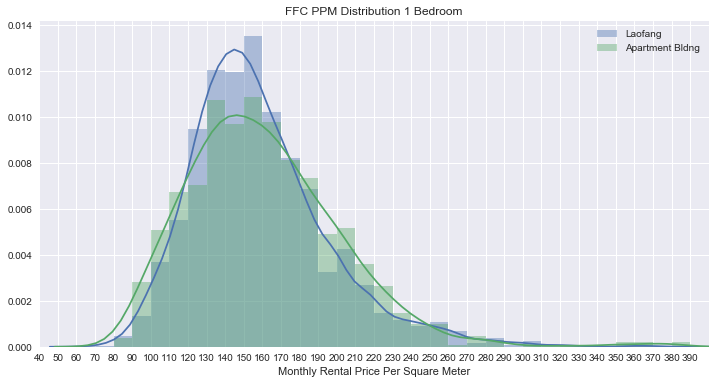

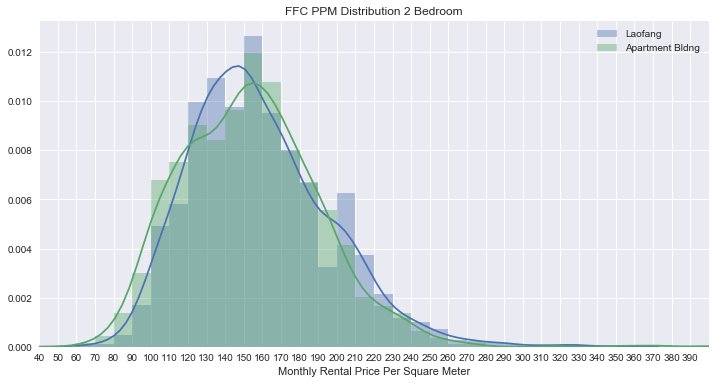

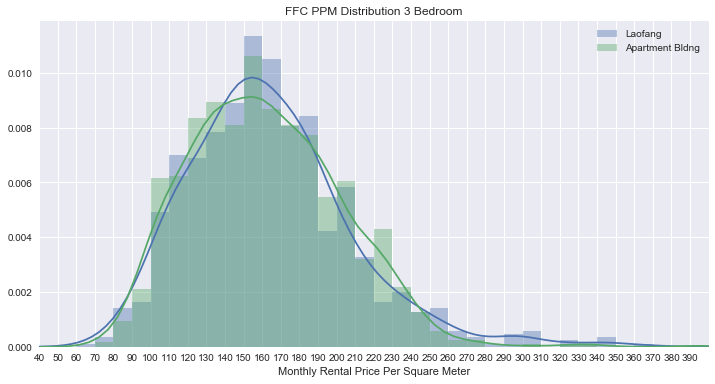

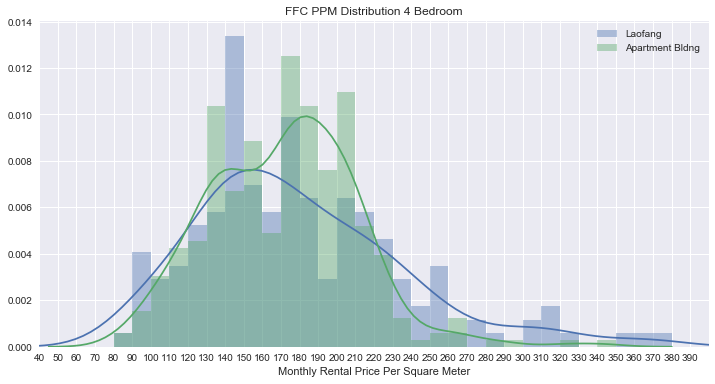

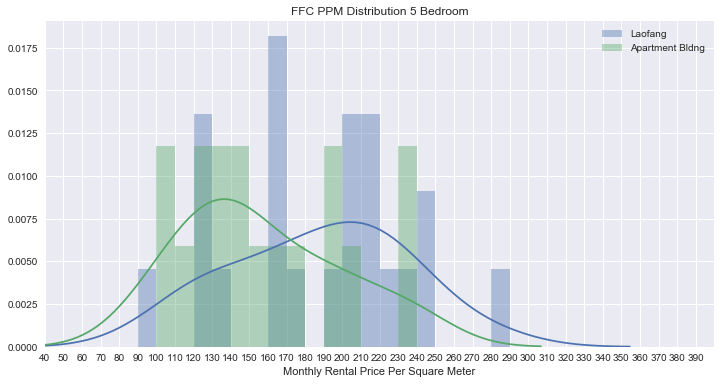

In [170]:
ffc = ['Yongkang Street','South Shaanxi Rd','Central Xintiandi','Southern Xintiandi'
       'Fuxing Park','Changshu Rd','West Nanjing Rd','Jing An Temple','Shanghai Library']
for a in [1,2,3,4,5]:
    plt.figure(figsize=(12,6))
    sns.set(color_codes=True)
    sns.distplot(df.loc[(df['district_dense'].isin(ffc)) &
                       (df['elevator']==0) & (df['rooms_BR']==a)]['price_per_meter'],
                 bins=np.arange(40,400,10),kde=True,label='Laofang')
    sns.distplot(df.loc[(df['district_dense'].isin(ffc))
                       & (df['elevator']==1) & (df['rooms_BR']==a)]['price_per_meter'],
                 bins=np.arange(40,400,10),kde=True,label='Apartment Bldng')
    plt.title("FFC PPM Distribution %s Bedroom" % a)
    plt.xticks(np.arange(40,400,10))
    plt.legend()
    plt.xlabel('Monthly Rental Price Per Square Meter')
    plt.xlim(40,400)
    plt.show()

# What influences difference in PPM?

In [ ]:
ffc = ['Yongkang Street','South Shaanxi Rd','Central Xintiandi','Southern Xintiandi'
       'Fuxing Park','Changshu Rd','West Nanjing Rd','Jing An Temple','Shanghai Library']
plt.figure(figsize=(16,6))
sns.set(color_codes=True)

sns.distplot(df.loc[(df['district_dense'].isin(ffc)) &
                   (df['rooms_BR']==1)]['price_per_meter'],
             bins=np.arange(40,400,10),kde=True,label='Non-Oven')
sns.distplot(df.loc[(df['district_dense'].isin(ffc))
                   & (df['rooms_BR']==3)]['price_per_meter'],
             bins=np.arange(40,400,10),kde=True,label='Oven')
plt.title("FFC PPM Distribution")
plt.xticks(np.arange(40,400,10))
plt.legend()
plt.xlim(40,400)
plt.show()
# 1. floor heating
# 2. wall_heating
# 3. pool
# 4. outdoor_space, dryer
# 5. health club
# 6. oven, central aircon
# 7. Water filter

# 0. Parking,tv, air_filter, balcony
# -1. security, dvd_player

# Do apartment buildings and laofangs have different ranges in Square Meterage?
### Laofang vs Apartment bldng square meterage distribution

In [ ]:
for a in [1,2,3,4,5]:
    plt.figure(figsize=(16,6))
    sns.set(color_codes=True)
    sns.distplot(df.loc[(df['district_dense'].isin(ffc)) &
                       (df['elevator']==0) & (df['rooms_BR']==a)]['size_int'],
                 bins=np.arange(20,400,10),kde=True,label='Laofang')
    sns.distplot(df.loc[(df['district_dense'].isin(ffc))
                       & (df['elevator']==1) & (df['rooms_BR']==a)]['size_int'],
                 bins=np.arange(20,400,10),kde=True,label='Apartment Bldng')
    plt.title("FFC Square Meterage Distribution %s Bedroom" % a)
    plt.xticks(np.arange(20,400,10))
    plt.legend()
    plt.xlim(20,400)
    plt.show()

In [ ]:
df_lf_agg = df.loc[df['district_dense'].isin(['South Shaanxi Rd','Changshu Rd',
                                 'Fuxing Park','Yongkang Street','Central Xintiandi','Jing An Temple',
                                  'West Nanjing Rd','Jiangsu Rd','Shanghai Library','Wuding Rd','East Wuding Rd',
                                 'Peoples Square','Dapuqiao','Jiashan Rd','North Laoximen','Southern Xintiandi',
                                 'Laoximen','Zhaojiabang Rd','Xujiahui','Hengfeng Rd','South Jiangning Rd',
                                  'Jiaotong Uni'] )
      ].loc[df['rooms_BR'].isin([1,2,3,4,5])].groupby(['rooms_BR','elevator']).agg(
    {'listing_id':'count','price':['median','mean',percentile(10),percentile(25),percentile(50),
                                   percentile(75),percentile(90),percentile(95)],'pool':'sum','oven':'sum',
     'rooms_BA':'mean','size_int':'mean','balcony':'sum','health_club':'sum','floor_heating':'sum','air_filter':'sum',
    'price_per_meter':['mean','median','std'],'size_int':['mean','median']}
)
df_lf_agg
df_lf_agg['oven_perc'] = df_lf_agg['oven']['sum']/df_lf_agg['listing_id']['count']
df_lf_agg[['listing_id','rooms_BA','price_per_meter','size_int','price','oven_perc']]

# Lane Houses and apartments are the same price per meter for 1-3 bedrooms. Once you get into 4 or 5 bedrooms you move
# into villa territory, 
# where you will pay much more rent on average per square meterage for lane house than you might an apartment building.

# On average you may pay more for a 1,2 bedroom place in a high-rise apartment building because when it comes to
# 1-2 bedrooms, rooms in apartment buildings are larger. 
# When we get to 3 bedrooms this starts to change, 3 bedroom lane houses are just as big as 3 bedroom apartments

# Apartment buildings and lane houses are equal in their variability in ppm, 
# i.e. they are equally likely to be very nice or very not nice. Niether or more standard. 
# This was very surprising to me

## Median 1 BR Price

In [ ]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='median_1br',
                          cutoff_count=30, title='1 Bedroom Median Price',
                          cutoff_field = 'count_1br',
                          excluded_districts=['Songyuan Rd'],
                          plot_width=1000, plot_height=700, color_mapper = LogColorMapper(RdBu[9]),
                          hover_tooltip=[('District','@TITLE'),("Median Price 1BR",'@median_1br_text'),("1BR Listings",'@count_1br')])

show(fig)

## Median 2BR Price

In [165]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='price_median_2br',
                          cutoff_count=20, title='2 Bedroom Median Price',
                          excluded_districts=['Tiantong Rd','Yili Rd','Songyuan Rd','Intl Passenger Transport Center'],
                         cutoff_field = 'count_2br',
                          toolbar_location=None,
                          plot_width=800, plot_height=600, color_mapper = LogColorMapper(RdBu[9]),
                          hover_tooltip=[('District','@TITLE'),("Median Price 2BR",'@price_median_2br_text'),("2BR Listings",'@count_2br')])


fig.add_layout(Label(x=121.505, y=31.260,
                 text='The Bund', render_mode='css',
                 border_line_color='black', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=1.0))

fig.add_layout(Arrow(end=OpenHead(line_color="firebrick", line_width=6),line_width=3,
                   x_start=121.505, y_start=31.26, x_end=121.488, y_end=31.245))

xu_lab_x=121.39
xu_lab_y = 31.17
xu_arr_xf = 121.428
xu_arr_yf = 31.19
fig.add_layout(Label(x=xu_lab_x, y=xu_lab_y,
                 text='Xujiahui', render_mode='css',
                 border_line_color='black', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=1.0))
fig.add_layout(Arrow(end=OpenHead(line_color="firebrick", line_width=6),line_width=3,
                   x_start=xu_lab_x, y_start=xu_lab_y, x_end=xu_arr_xf, y_end=xu_arr_yf))

fig.line([121.434,121.484],[31.195,31.24],line_dash='dashed',color='blue',line_width=4)

fig.add_layout(Label(x=121.388, y=31.252,
                 text='Jing\'An Temple', render_mode='css',
                 border_line_color='black', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=1.0))

fig.add_layout(Arrow(end=OpenHead(line_color="firebrick", line_width=3),line_width=2,
                   x_start=121.388, y_start=31.252, x_end=121.447, y_end=31.225))

fig.add_layout(Label(x=121.385, y=31.229,
                 text='Jiangsu Rd', render_mode='css',
                 border_line_color='black', border_line_alpha=0,
                 background_fill_color='white', background_fill_alpha=1.0))

fig.add_layout(Arrow(end=OpenHead(line_color="firebrick", line_width=3),line_width=2,
                   x_start=121.385, y_start=31.229, x_end=121.426, y_end=31.218))
show(fig)

## Median 3BR Price

In [ ]:
fig = bokeh_plot_shanghai(df=df_dist_d,field='median_3br',
                          cutoff_count=50, title='3 Bedroom Median Price',
                          excluded_districts=[],
                         cutoff_field = 'count_3br',
                          plot_width=1000, plot_height=700, color_mapper = LogColorMapper(RdBu[9]),
                          hover_tooltip=[('District','@TITLE'),("Median Price 3BR",'@median_3br_text'),("3BR Listings",'@count_3br')])

show(fig)

# ML

In [ ]:
from scipy.stats import pearsonr
features  = checkbox_cols + ['rooms_BA','floor']
target='price_per_meter'
correlations = {}
for f in features:
    df_temp = df[[f,target]]
    x1 = df_temp[f].values
    x2 = df_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

## Lingear Regression

In [ ]:
import lightgbm as lgb
from matplotlib import interactive
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
plt.style.use('bmh')
interactive(True)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, auc
from sklearn.metrics import explained_variance_score
df_ml = df[checkbox_cols + ['district_dense','rooms_BR','rooms_BA','floor','price_per_meter']]
df_dum = pd.get_dummies(df_ml['district_dense'])
df_ml = pd.concat([df_ml.drop(['district_dense'],axis=1), df_dum], axis=1)
y = df_ml['price_per_meter']
X = df_ml.drop(['price_per_meter'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LinearRegression(normalize=True)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
explained_variance_score(y_test,y_pred)
r2_score(y_test,y_pred)

In [ ]:
# Let's try XGboost algorithm to see if we can get better results
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)

In [ ]:
from xgboost import plot_importance
fig = plt.figure(figsize=(12,20))
ax = fig.gca()
plot_importance(xgb,ax=ax)

In [ ]:
from xgboost import plot_tree
df_ml = df[checkbox_cols + ['rooms_BR','rooms_BA','floor','price_per_meter']]
# df_dum = pd.get_dummies(df_ml['district_dense'])
# df_ml = pd.concat([df_ml.drop(['district_dense'],axis=1), df_dum], axis=1)
y = df_ml['price_per_meter']
X = df_ml.drop(['price_per_meter'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LinearRegression(normalize=True)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
explained_variance_score(y_test,y_pred)
r2_score(y_test,y_pred)

# Let's try XGboost algorithm to see if we can get better results
import xgboost
xgb2 = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb2.fit(X_train,y_train)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
plot_importance(xgb2,ax=ax)

In [ ]:
from xgboost import to_graphviz
to_graphviz(xgb2, num_trees=1)

In [ ]:
from sklearn.metrics import explained_variance_score
y_pred = xgb.predict(X_test)
print(r2_score(y_test,y_pred))
print(explained_variance_score(y_test,y_pred))

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train,label=y_train)
test_data = lgb.Dataset(X_test,label=y_test)
param = {'num_leaves':15, 'num_trees':2000,'objective':'regression'}
num_round = 10
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data])
feat_import = bst.feature_importance()
fdf = pd.DataFrame(feat_import,index=X_train.columns,columns=['feat_import'])
# fdf.sort_values(by=['1'],axis=0)
fdf.sort_values(by='feat_import',ascending=False)
# fdf